# Putting the p-value in Context

Neuroscience researchers typically report p-values to express the strength of statistical evidence; but p-values are not sufficient on their own to understand the meaning and value of a scientific inference. In this unit, learners will learn how to interpret the p-value, how to express the size of an effect and uncertainty about a result, and how to interpret results at both the individual and population levels.

<div class="alert alert-block alert-danger">
<b>Alert:</b> If you're running this on <b>Google Colab</b>, then uncomment and run the next two cells.
</div>

In [1]:
# !git clone https://github.com/Mark-Kramer/METER-Units.git

In [2]:
# import sys
# sys.path.insert(0,'/content/METER-Units')

# 1 - Here’s some data, give me the p’s!

In [3]:
# Load modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from pvalue_functions import *

<div class="alert alert-block alert-info">

## Introduction
- Your lab collects an EEG biomarker of memory ([sleep spindles](https://en.wikipedia.org/wiki/Sleep_spindle)) from N=20 human subjects.

- To do so, your lab measures the [power](https://mark-kramer.github.io/Case-Studies-Python/03.html) in the spindle band (9-15 Hz) twice per minute. Your lab has a [reliable method](https://mark-kramer.github.io/Case-Studies-Python/04.html#multitaper) to detect spindle activity; this detector is known to be accurate outside of treatment. We expect it to still work during treatment, but we also expect more variability in the spindle power estimates (hence more variability in the detections) during treatment.
    
- For each subject, your lab measures spindle activity during three conditions:
    
    - **Baseline**: Data collection lasts 7 hours while the subject sleeps on an evening before the intervention. This results in 840 samples of spindle activity for each subject.
    
    - **During Treatment**: Data collection during a 15 minute intervention during sleep, resulting in 30 samples of spindle activity for each subject.
    
    - **Post-treatment**: Data collection after intervention lasts 7 hours, while the subject sleeps, resulting in 840 samples of spindle activity for each subject.

Here's a graphical representation of the data collected from one subject:
![title](IMG_Pvalue/Data_Layout.jpg)

Your PI says: "*I want to know if there’s an effect of treatment in each human. **Give me the p-values!***"

</div>

<div class="alert alert-block alert-success">
    

**Q:** What does the PI mean by *"Give me the p-values"*?

**A:** (Short answer)

Example Learner Answers:
1. The PI wants the p-values from tests comparing spindle activity across conditions.  
2. They mean to test if treatment significantly changed spindle power within each subject.  
3. The PI is asking for p-values to determine if there’s a statistical effect of treatment.  
4. It means running tests to see if spindle activity differs between Baseline, Treatment, and Post-treatment.  
5. The PI wants statistical evidence to show treatment effects on spindle activity.  
</div>

Perhaps you've never computed a p-value before ...

That's ok. In this unit, you will learn to compute p-values and gain intuition for what a p-value means (and what it doesn't).

Even if you've *never* computed a p-value before, do your best to answer the questions below.

<div class="alert alert-block alert-success">
    
**Q:** For each scenario below, decide if it is appropriate to use a p-value to address the research question (answer yes or no).
    
1. Does the proportion of people who prefer brand A over brand B differ from 50%?  
2. What is the exact average height of an adult giraffe in meters?  
3. Does a new vaccine significantly reduce infection rates compared to the old vaccine?  
4. How long does it take to completely drain a 50,000-gallon swimming pool?  
5. Does changing the color of a website’s button increase user clicks statistically significantly?  

**A:** 
1. Yes, because we can statistically test if the proportion differs from 50%.  
2. No, because we are looking for an exact value rather than testing a hypothesis.  
3. Yes, because we can test if the new vaccine’s effect differs significantly from the old one.  
4. No, because it’s a direct measurement rather than a hypothesis test.  
5. Yes, because we can compare the click rates before and after the color change to see if the difference is statistically significant.
</div>

<div class="alert alert-block alert-success">

**Q:** Have you ever computed a p-value (in software)?

**A:** (Survey)
</div>

# 2- Let’s do it: Define & compute p-values.


Before we compute p-values, let's consider what a p-value means ...


### What does a p-value test?

Sometimes statisticians think backwards. We'd like to know how the spindle activity changes relative to baseline. To test this, we'll start by assuming the opposite: we'll hypothesize that the spindle activity does not change. This is called the **null hypothesis**. The p-value indicates how much evidence we have to reject the null hypothesis given the data we observe. It's like a measure of surprise. If we're surprised by the observed data, then we'll reject the null hypothesis, and conclude we have evidence that the spindle activity changes relative to baseline.

Alternatively, if we're *not* surprised by the observed data, then we'll conclude that we lack sufficient evidence to reject the null hypothesis. There's an important subtely here that statisicians like to point out - when we're testing this way, **we never accept the null hypothesis**. Instead, the best we can do is talk like a statistican and say things like "we fail to reject the null hypothesis".

<div class="alert alert-block alert-success">

**Q:** The PI says *“I expect that during treatment the spindle activity exceeds the baseline spindle activity.”* What is the null hypothesis?

**A:** (Multiple Choice)

Wrong answer: The average spindle activity during treatment is guaranteed to be higher than baseline.

Wrong answer: The average spindle activity during treatment is guaranteed to be lower than baseline.

Wrong answer: A difference in average spindle activity exists between treatment and baseline.

Correct answer: No difference in average spindle activity exists between treatment and baseline.

</div>

### What does p<0.05 mean?

The probability of observing the data, or something more extreme, under the null hypothesis is less than 5%. This is typically considered sufficient evidence to reject the null hypothesis in favor of the alternative hypothesis (which posits that there is an effect or a difference). In other words, a p-value less than 0.05 suggests that the observed data is unlikely to have occurred by random chance alone, assuming the null hypothesis is true, leading researchers to reject the null hypothesis.

In our case, the null hypothesis we will first investigate is:

**Null hypothesis:** No difference in average spindle activity  between treatment and baseline conditions.

<div class="alert alert-block alert-success">

**Q:** Which of the following factors might impact the evidence you have to reject this null hypothesis?

**A:** (Multiple Choice - all are correct)

- **Sample Size**: Collecting more spindle samples reduces random error and provides more precise estimates.  
- **Effect Size**: Bigger differences in spindle activity between conditions are easier to detect.  
- **Variability (or Noise) in Measurements**: High variability in the spindle estimates during treatment can make it harder to detect a real effect.  

</div>

Now, let's load the spindle data and compute p-values to test our null hypothesis

In [4]:
baseline, during_treatment, post_treatment = load_data()

Let's start by investigating the structure of the data.

In [5]:
print(baseline.shape)
print(during_treatment.shape)
print(post_treatment.shape)

(840, 20)
(30, 20)
(840, 20)


All three variables consist of observations from 20 subjects (the number of columns). We collect 30 samples during treatment and 840 samples at baseline (i.e., before treatment) and after treatment; this is the the number of rows for each variable.

You might think of these variables as rectangles (or matrices), where each row indicates a sample of spindle activity, and each column indicates a subject:

![title](IMG_Pvalue/simple_boxes_during_and_post.jpg)

<div class="alert alert-block alert-success">

**Q:** Look at the representations of the data above. What differs about the data during treatment, compared to baseline and post-treatment?

**A:** (Multiple Choice)

Wrong answer: There are fewer subjects during treatment.

Correct answer: There are fewer samples during treatment.

</div>

To get a sense for the the data, let's plot the spindle activity during `baseline`, `treatment`, and `post-treatment` conditions for one subject:

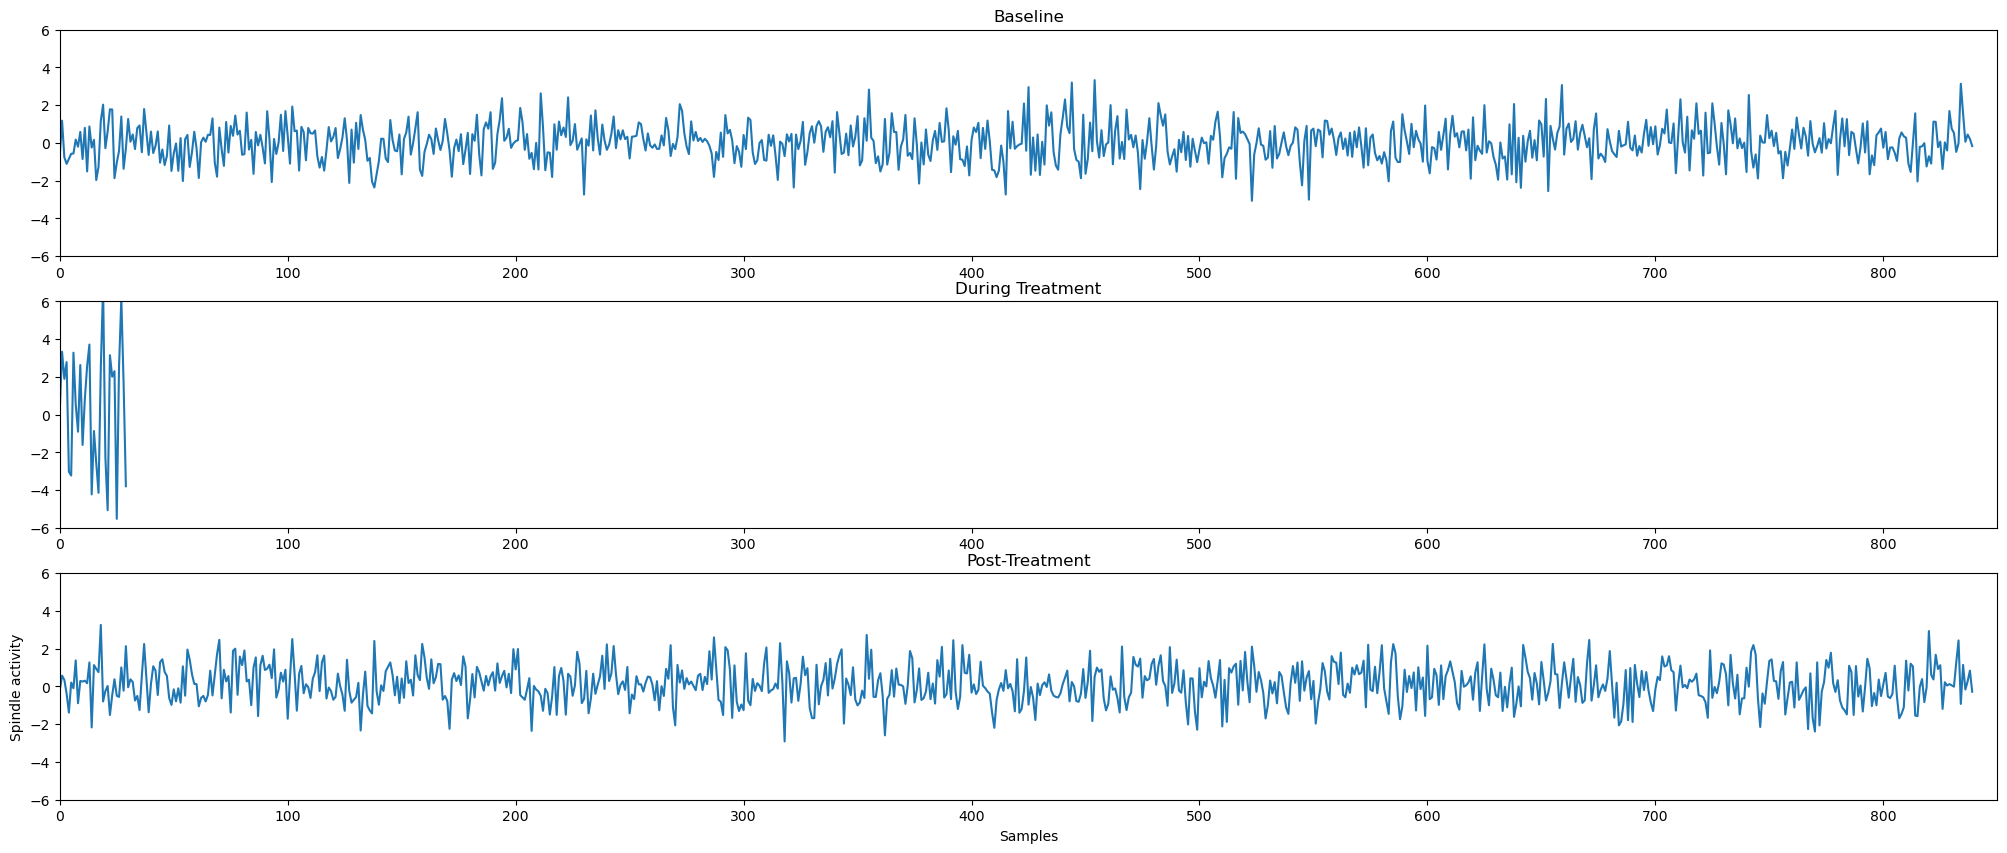

In [6]:
f, ax = plt.subplots(3,1, figsize=(25,10))
ax[0].plot(baseline[:,0]); ax[0].set_xlim([0,850]); ax[0].set_ylim([-6,6]); ax[0].set_title('Baseline');
ax[1].plot(during_treatment[:,0]); ax[1].set_xlim([0,850]); ax[1].set_ylim([-6,6]); ax[1].set_title('During Treatment');
ax[2].plot(post_treatment[:,0]); ax[2].set_xlim([0,850]); ax[2].set_ylim([-6,6]); ax[2].set_title('Post-Treatment');
plt.xlabel('Samples'); plt.ylabel('Spindle activity');

<div class="alert alert-block alert-success">

**Q:** What values do you observe for the spindle activity?

**A:** The values tend to fluctuate around 0, and can be both positive and negative.
</div>

Here, the spindle activity has been z-scored during each recording interval relative to baseline. So, the values we observe indicate changes relative to the mean baseline spindle activity; positive (negative) values indicate increases (decreases) in spindle activity relative to the baseline activity.

<div class="alert alert-block alert-success">

**Q:** What differences or similarites do you notice in spindle activity durint the `baseline`, `treatment`, and `post-treatment` conditions for this subject?

**A:** Similarities:
- All fluctuate around 0. This makes sense because all values are normalized relative to the mean baseline spindle activity.

Differences:
- During treatment there are fewer samples.
- During treatment, the fluctuations are bigger (the data are more variable).
</div>

<div class="alert alert-block alert-success">

**Q:** During `treatment`, we collect fewer, noiser samples compared to the `baseline` and `post-treatment` conditions. How might these factors impact the evidence we have to reject the null hypothesis:

**Null hypothesis:** No difference in average spindle activity between treatment and baseline conditions.

**A:** (Multiple Choice)

- (Incorrect) Fewer spindle samples increases our evidence.
- (Correct) Fewer spindle samples decreases our evidence.
- (Incorrect) Noiser spindle samples increases our evidence.
- (Correct) Noiser spindle samples decreases our evidence.
</div>

### Let's now compute the p-values during `treatment`.

To do so, we again assume the null hypothesis:

**Null hypothesis:** No difference in average spindle activity between treatment and baseline conditions.

Because we've subtracted the mean baseline spindle rate from each treatment observation, our null hypothesis becomes:

**Null hypothesis**: Mean spindle rate during treatment = 0.

In [7]:
result = stats.ttest_1samp(during_treatment, popmean=0)
p_value_during = result.pvalue

The list above consists of 20 p-values, one for each subject.

Each p-value indicates the probability of observing the data, or something more extreme, under the null hypothesis:

**Null hypothesis**: Mean spindle rate during treatment = 0.

Let's print the p-values for each subject:

In [8]:
for k in np.arange(0,20):
    print('Subject ', k, ', p=', np.array2string(p_value_during[k], precision=2))

Subject  0 , p= 0.52
Subject  1 , p= 0.89
Subject  2 , p= 0.63
Subject  3 , p= 0.22
Subject  4 , p= 0.01
Subject  5 , p= 0.31
Subject  6 , p= 0.01
Subject  7 , p= 0.99
Subject  8 , p= 0.09
Subject  9 , p= 0.26
Subject  10 , p= 0.07
Subject  11 , p= 0.14
Subject  12 , p= 0.02
Subject  13 , p= 0.12
Subject  14 , p= 0.19
Subject  15 , p= 0.73
Subject  16 , p= 0.3
Subject  17 , p= 0.46
Subject  18 , p= 0.05
Subject  19 , p= 0.29


<div class="alert alert-block alert-success">

**Q:** For Subject 0, we find $p=0.52$. What does this mean?

**A:** (Multiple Choice)

1. (Incorrect) There is a 52% chance that the mean spindle rate is truly zero.  
2. (Correct) There is a 52% probability of observing these data (or something more extreme) if the mean spindle rate is zero.
3. (Incorrect) There is a 48% probability that the alternative hypothesis is correct.  
4. (Incorrect) There is a 52% chance that the result is clinically meaningful.
</div>

Let's also plot the p-values:

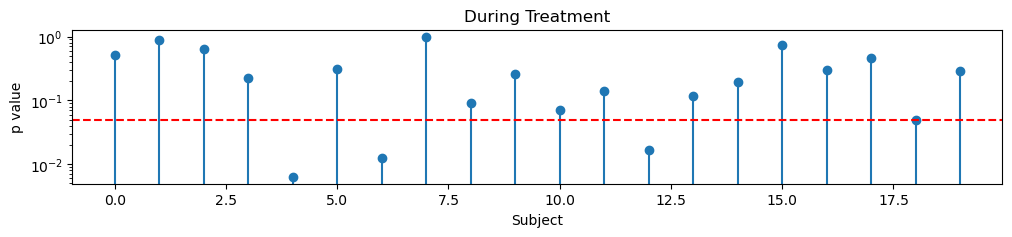

In [9]:
# Plot the p-values during treatment
plt.figure(figsize=(12, 2))
plt.stem(p_value_during);
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('During Treatment'); plt.yscale('log')

<div class="alert alert-block alert-success">

**Q:** Interpert the print-out and plots of p-values. What do you see?

**A:** The p-values tend to exceed 0.05 (red dashed line in the figure), although a few subjects have p<0.05.

</div>

## Do we have evidence to reject the null hypothesis?

Maybe ... if we had performed one statistical test, then we typically reject the null hypothesis if

`p < 0.05`

But here we compute 20 test (one for each subject).

When we perform multiple tests, it's important we consider the impact of **multiple comparisons**. We cover this topic in detail in the [Multiplicity Unit](https://github.com/Mark-Kramer/METER-Units/blob/main/METER_Exploratory.ipynb).

Here we'll chose a specific approach to deal with multiplicity - we'll apply a **Bonferroni correction**. The Bonferroni correction reduces the Type I error rate by dividing the desired overall significance level (here 0.05) by the number of tests performed (here 20 tests, one test per subject). Stated simply, the Bonferroni test adjusts the significance level by dividing it by the number of tests we perform. Doing so reduces the risk of false positives (Type I errors); or more information, see [Multiplicity Unit](https://github.com/Mark-Kramer/METER-Units/blob/main/METER_Exploratory.ipynb).

So, for our analysis of the p-values from 20 subjects, let's compare the p-values to a stricter threshold of

`p < 0.05 / 20` or `p < 0.0025`

Thresholding in this way provides a binary, yes/no answer to the question: do we have evidence that the spindle activity during treatment differs from 0?

Let's plot the p-values versus this new threhsold.

Significant p-values during treatment =  0


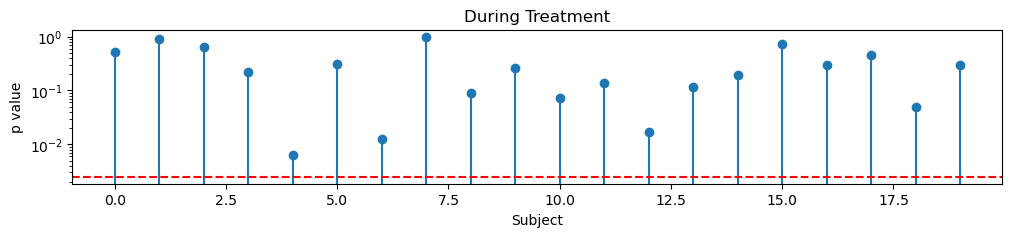

In [10]:
# Plot the p-values during treatment
plt.figure(figsize=(12, 2))
plt.stem(p_value_during);
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('During Treatment'); plt.yscale('log')

print('Significant p-values during treatment = ',np.sum(p_value_during < 0.05/20))

<div class="alert alert-block alert-success">

**Q:** After the Bonferroni correction, can we reject the null hypothesis for any subject?

**A:** (Multiple Choice)

1. (Correct) No. None of the p-values are less than 0.05/20.
2. (Incorrect) Yes. Some of the p-values are small enough.

</div>

<div class="alert alert-block alert-success">

**Q:** The PI requested *“Give me the p’s!”*. Do you have evidence to reject the null hypothesis during treatment?

**A:** (Multiple Choice)

1. (Correct) No! The p-values are large, so we find no evidence to reject the null hypothesis for any subject.
2. (Incorrect) Yes! The p-values are large, so the spindle activity during treatment is large.

</div>

<div class="alert alert-block alert-success">

**Q:** We do not find any p-values that pass our significance threshold during treatment. Does this mean that the spindle activity during treatment does not change relative to baseline?

**A:** (Multiple Choice)

1. (Correct) No! We never accept the null hypothesis. Remember we have to talk like a statistician. Instead, we say: *"We fail to reject the null hypothesis that the spindle activity during treatment differs from baseline."*
2. (Incorrect) Yes! Because the p-values are large, we can accept the null hypothesis.

</div>

<div class="alert alert-block alert-danger">
<b>Summary:</b>
    
    
We've done this for each subject. Our intial results suggest provide **no evidence** that we can reject the null hypothesis during treatment.

</div>

### Mini Summary & Review

We sought to answer the scientific question:
- Does the spindle activity during `treatment` differ from the `baseline` spindle activity?

To answer this question, we assumed a **Null hypothesis** of no difference in spindle activity during `treatment` compared to 0.

We tested this null hypothsis for each subject, computing a p-value for each subject.

Because we computed 20 p-values (one for each subject), we corrected for multiple comparsions using a Bonferroni correction (see [Multiplicity Unit](https://github.com/Mark-Kramer/METER-Units/blob/main/METER_Exploratory.ipynb)).

We found no p-values small enough to reject the null hypothesis. 

In other words, using our initial approach, we found **no evidence** that the spindle activity during `treatment` differ from `baseline`.

<div class="alert alert-block alert-success">
    
**Q:** Our initial results provide we found **no evidence** that the spindle activity during `treatment` differ from `baseline`. The spindle activity *might* differ between the two conditions, but our data and analysis approach don't provide supporting evidence. What factors might impact our evidence?

**A:** (Multiple choice - all correct)

- **Sample Size**: We collect only 30 spindle samples during `treatment`, which increases random error and provides less precise estimates.
- **Effect Size**: Small differences in spindle activity between conditions are difficult to detect.  
- **Variability (or Noise) in Measurements**: High variability in the spindle estimates during treatment can make it harder to detect a real effect.
- **Approach to Statistical Testing:** A different approach may provide more insight into difference in spindle activity between the `treatment` and `baseline`
- **Treatment has no Effect:** It may be that the treatment does not impact spindle activity relative to baseline.
</div>

# 3- Maybe there's something else we can publish?

The results in Mini 2 are discouraging; we find no evidence of a change in spindle activity from baseline during treatment.

That's dissappointing. Rather than abandon our data (which took years to collect), our PI asks us we continue **exploring the data**.

**Data exploration is common in neuroscience.** In general, as practicing neuroscientists, we explore our data for interesting features.

However, when undertaking data exploration, we must make it clear (e.g., by reporting what we explored, whether the results are significant or not).

Our PI recommends that we **examine the change in spindle activity `post-treatment`**.

Perhaps the treatment produces a longer-term affect that manifests during the `post-treatment` period.

<div class="alert alert-block alert-success">

**Q:** Given this new analysis, what is the null hypothesis?

**A:** (Multiple Choice)

1. (Correct) No difference in average spindle activity between `post-treatment` and `baseline` conditions.
2. (Incorrect) The average spindle activity is higher `post-treatment` compared to `baseline`.
3. (Incorrect) The average spindle activity is lower `post-treatment` compared to `baseline`.

</div>

For our new analysis, our null hypothesis now focuses on the `post-treatment` data:

**Null hypothesis**: Mean spindle activity `post-treatment` = 0
    
Remeber, we've subtracted the `baseline` spindle activity from the `post-treatment` values.

So, no change in spindle activity `post-treatment` (our null hypothesis) would result in values the fluctuate around 0.

</div>

<div class="alert alert-block alert-success">

**Q:** How do data in the `post-treatment` condition differ from the `treatment` condition?

**A:** (Many Choice)

1. (Correct) The number of samples is higher in the `post-treatment` condition.
2. (Incorrect) The number of subjects is higher in the `post-treatment` condition.
3. (Correct) The spindle estimates are less noisy in the `post-treatment` condition.
2. (Incorrect) The spindle estimates are more noisy in the `post-treatment` condition.
</div>

During the `post-treatment` condition:
- we have many more samples to analyze (N=840) compared to the `treatment` condition (N=30).
- the spindle estimates are less noisy compared to the `treatment` condition

<div class="alert alert-block alert-success">

**Q:** How do these two factors impact the evidence we have to reject the null hypothesis?

**A:** (Multiple Choice - all correct)
- **Sample Size**: Collecting more spindle samples reduces random error and provides more precise estimates.  
- **Variability (or Noise) in Measurements**: Lower variability in the spindle estimates `post-treatment` can make it easier to detect an effect.  
</div>

Let's repeat the analysis in Mini 2, but now examining the `post-treatment` spindle activity.

In [11]:
result = stats.ttest_1samp(post_treatment, popmean=0)
p_value_post = result.pvalue

Let's print and plot the p-values for each subject:

In [12]:
for k in np.arange(0,20):
    print('Subject ', k, ', p=', np.array2string(p_value_post[k], precision=2))

Subject  0 , p= 7.1e-05
Subject  1 , p= 6.84e-07
Subject  2 , p= 0.02
Subject  3 , p= 7.58e-05
Subject  4 , p= 4.28e-05
Subject  5 , p= 0.17
Subject  6 , p= 0.02
Subject  7 , p= 0.01
Subject  8 , p= 0.01
Subject  9 , p= 0.24
Subject  10 , p= 0.03
Subject  11 , p= 0.
Subject  12 , p= 0.
Subject  13 , p= 0.42
Subject  14 , p= 1.95e-06
Subject  15 , p= 0.69
Subject  16 , p= 0.
Subject  17 , p= 0.03
Subject  18 , p= 0.
Subject  19 , p= 0.01


<div class="alert alert-block alert-success">

**Q:** For Subject 0, we find $p=7.1e-05$. What does this mean?

**A:** (Multiple Choice)

1. (Incorrect) There is a small chance that the mean spindle rate is truly zero.
2. (Incorrect) There is a small chance that the mean spindle rate is truly nonzero.  
3. (Correct) There is a small probability of observing these data (or something more extreme) if the mean spindle rate is zero.
5. (Incorrect) There is a small chance that the result is clinically meaningful.
</div>

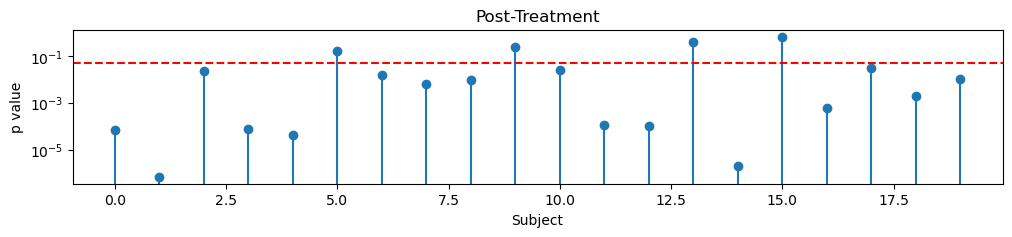

In [13]:
# Plot the p-values post-treatment
plt.figure(figsize=(12, 2))
plt.stem(p_value_post);
plt.axhline(y=0.05, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('Post-Treatment'); plt.yscale('log')

Because we've computed 20 p-values (one from each subject), let's again correct for multiple compariosns using a Bonferroni correction (see [Multiplicity Unit](https://github.com/Mark-Kramer/METER-Units/blob/main/METER_Exploratory.ipynb)).

Significant p-values post-treatment =  9


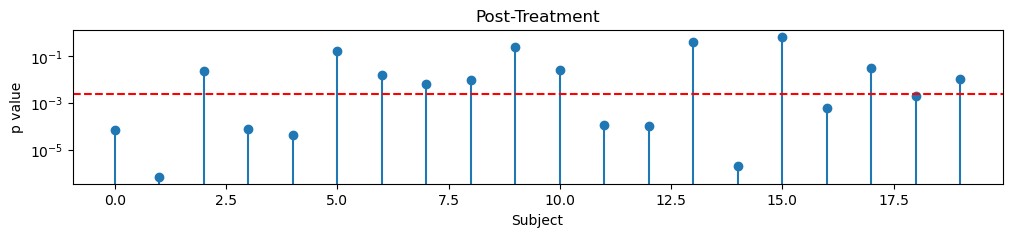

In [14]:
plt.figure(figsize=(12, 2))
plt.stem(p_value_post);
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('Post-Treatment'); plt.yscale('log')
print('Significant p-values post-treatment = ',np.sum(p_value_post < 0.05/20))

<div class="alert alert-block alert-success">

**Q:** Compare these two sets of p-values, calculated during treatment (Mini 2) and post-treatment. What does it mean?

**A:** (Multiple Choice)

1. (Correct) No. None of the p-values are small enough (less than 0.05/20).
2. (Incorrect) Yes. Some of the p-values are small enough (less than 0.05/20).

Look at how small the p-values are `post-treatment`!

 - 9 p-values post-treatment are less than 0.05/20, the Bonferroni corrected p-value threshold.

Remembe that, during `treatment`, the p-values are much larger, and we find no p-values less than  0.05/20.

We find many more significant p-values `post-treatment` (9 out of 20, after Bonferroni correction).
</div>

### Our results **seem** to reveal a new conclusion: 

- In Mini 2, we found no evidence of a change in spindle activity `during treatment`.
- In this Mini, we find many very small p-values (less than 0.05/20) `post-treatment`.

More specifically, we find evidence of a significant change in spindle activity post-treatment in 9/20 subjects.

The PI is very excited with our new results, which appear to upend the literature.

The PI drafts the title for a high-impact paper:

- Draft paper title: *Post-Treatment Paradox: Clear Human Responses, Despite Absence of Treatment Effect*

## But are we sure?

<div class="alert alert-block alert-success">

**Q:** Review the characteristics of data during `treatment` and `post-treatment`. How might these characteristics impact the p-values we observe?

**A:** (Multiple Choice - all correct)

1. We collect more samples `post-treatment`, which can provide more precise estimates.
2. We collect fewer samples during `treatment`, which can provide less precise estimates.
3. The measures are less noisy `post-treatment`, which can make it easier to detect an effect.  
4. The measures are more noisy during `treatment`, which can make it harder to detect an effect.  
</div>

This is a very important question ... and we haven't fully answered it yet.

We collect many more samples `post-treatment`, and our measurements are more accurate `post-treatment` compared to during `treatment`. Both of these features impact the evidence we collect to reject the null hypothesis.

## So, are you sure about the `post-treatment` results?

<div class="alert alert-block alert-danger">
<b>Alert: Wait, I'm not so sure ... </b>

</p>

- Why did you ask me to review the characteristics of the data, and think about how this might impact the data?
</div>

<div class="alert alert-block alert-info">

*Moment of tension*:

- Hook the learner - "something isn't right and I want to know why."

</div>

<div class="alert alert-block alert-success">

**Q:** EXTENSION PROGRAMMING EXERCISE: We've examined the spindle activity during `treatment` and `post-treatment`. How would you test the null hypothesis of spindle activity = 0 during the `baseline` condition?

</div>

### Mini Summary & Review

We sought to answer the scientific question:
- Does the spindle activity `post-treatment` differ from the `baseline` spindle activity?

To answer this question, we assumed a **Null hypothesis** of no difference in spindle activity `post-treatment` compared to 0.

We tested this null hypothsis for each subject, computing a p-value for each subject.

Because we computed 20 p-values (one for each subject), we corrected for multiple comparsions using a Bonferroni correction (see [Multiplicity Unit](https://github.com/Mark-Kramer/METER-Units/blob/main/METER_Exploratory.ipynb)).

We found many p-values small enough to reject the null hypothesis. 

In other words, in this exploratory analysis, we found **evidence** that the spindle activity during `post-treatment` differs from `baseline`.

This differs from our results during `treatment`, in which we found **no evidence** that the spindle activity during `treatment` differs from `baseline`.

# 4- Not so fast: visualize the measured data, always.

In Mini 3, we *may* have found an interesting result: spindle activity `post-treatment`, but not during `treatment`, differs from `baseline`.

Scientifically, we might conlcude that our treatment has a long-lasting effect, impacting spindle activity `post-treatment`.

To infer these results, we computed and compared p-values, testing specific null hypotheses for each subject.

We've hinted above that **something isn't right** ... let's now dive in and identify what we could have done differently.

**Our initial approach has focused exclusively on p-values.**

P-values indicate how much evidence we have to reject a null hypothesis given the data we observe.

Let's again plot the p-values during `treatment` and `post-treatment` for each subject:

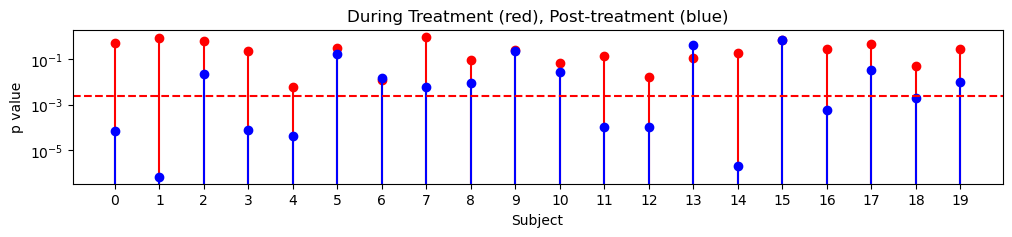

In [15]:
plt.figure(figsize=(12, 2))
l1 = plt.stem(p_value_during, 'or')
l2 = plt.stem(p_value_post, 'ob')
plt.yscale('log')
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xticks(np.arange(0,20));
plt.xlabel('Subject'); plt.ylabel('p value');
plt.title('During Treatment (red), Post-treatment (blue)');

<div class="alert alert-block alert-success">

**Q:** For each subject, compare the p-values during `treatment` (red) versus `post-treatment` (blue). What do you observe?

**A:** (Multiple Choice)

1. (Correct) P-values tend to be smaller `post-treatment` compared to during `treatment`.
2. (Incorrect) P-values tend to be larger `post-treatment` compared to during `treatment`.

</div>

We've focused on p-values to draw our scientific conclusions. 

**However, we've almost completely ignored the spindle measurements themselves!**

Let's return to the spindle activity measurements themselves, and see how these measurements relate to the p-values.

<div class="alert alert-block alert-success">

**Q:** Consider Subject 4. We find during `treatment` p=0.01, and `post-treatment` p=4.28e-05. So, the p-value is much smaller `post-treatment`. How do you think the **spindle activity** differs during `treatment` versus `post-treatment`.

**A:** (Multiple Choice)

1. (Incorrect) The p-value is smaller `post-treatment`, so I expect a big effect - I expect spindle activity that differs from 0.
2. (Incorrect) The p-value is bigger during `treatment`, so I expect a small effect  - I expect spindle activity near 0.
3. (Correct) It's dangerous to deduce effect size from the p-value.

</div>

<div class="alert alert-block alert-success">

**Q:** Consider the p-values computed for all subjects. How do you expect the **spindle activity** behaves during `treatment` and `post-treatment`?

**A:** (Multiple Choice)
1. Because we **do not** find significnat p-values during `treatment`, I expect these values to appear near 0.
2. Because we **do** find significnt p-values `post-treatment`, I expect these values to differ from 0.
3. (Correct) It's dangerous to deduce effect size from the p-value.

</div>

Now, let's return to the spindle activity and look at those values directly.

Let's begin with an example from Subject 4.

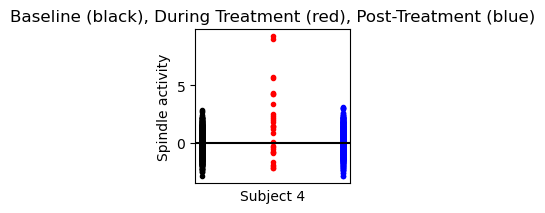

In [16]:
plt.figure(figsize=(2, 2))
plt.plot(np.tile(0,(840,1))-0.25, baseline[:,4], '.', color='k')
plt.plot(np.tile(0,(30,1)), during_treatment[:,4], '.', color='r')
plt.plot(np.tile(0,(840,1))+0.25, post_treatment[:,4], '.', color='b')
plt.axhline(y=0, color='k')
plt.xlabel('Subject 4'); plt.ylabel('Spindle activity'); plt.title('Baseline (black), During Treatment (red), Post-Treatment (blue)'); #plt.ylim([0,1]);
plt.xticks([]);

For Subject 4, we found:

- `treatment`   p=0.01
- `post-treatment` p=4.28e-05

From these p-values, we might expect:

- Spindle activity during `treatment` near 0 (i.e., similar to `baseline`).
- Spindle activity `post-treatment` far from 0 (i.e., different from `baseline`).

But, we **find the opposite**.

- Spindle activity during `treatment` far from 0 (i.e., different from `baseline`).
- Spindle activity `post-treatment` near 0 (i.e., similar to `baseline`).

Let's make similar plots for all 20 subjects.

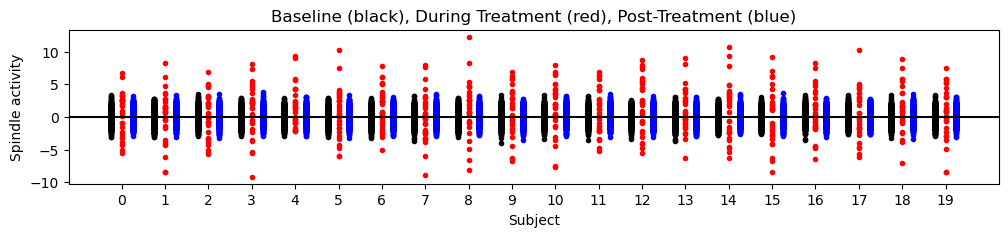

In [17]:
plt.figure(figsize=(12, 2))
for k in np.arange(0,20):
    plt.plot(np.tile(k,(840,1))-0.25, baseline[:,k], '.', color='k')
for k in np.arange(0,20):
    plt.plot(np.tile(k,(30,1)), during_treatment[:,k], '.', color='r')
for k in np.arange(0,20):
    plt.plot(np.tile(k,(840,1))+0.25, post_treatment[:,k], '.', color='b')
plt.axhline(y=0, color='k')
plt.xlabel('Subject'); plt.ylabel('Spindle activity'); plt.title('Baseline (black), During Treatment (red), Post-Treatment (blue)'); #plt.ylim([0,1]);
plt.xticks(np.arange(0,20));

<div class="alert alert-block alert-success">

**Q:** Looking at the plots of spindle measurements, do you observe an effect during `treatment` (red) compared to `baseline` (black)?

**A:** (Short answer)

- (Correct) Yes, sort of ... the spindle measurements during treatment appear larger than than baseline. How can that be if the p-values are big?
</div>

<div class="alert alert-block alert-success">

**Q:** Looking at the plots of spindle measurements, do you observe an effect `post-treatment` (red) compared to `baseline` (black)?

**A:** (Short answer)

- (Correct) Not really ... because we find significant p-values `post-treatment`, I expected these values to differ from 0 and from the distribution of `baseline` values. But I don't see that here ...
3. Not really ... we concluded that there's an effect post-treamtnet, but not during treatment. However, these plots of spindle measurements aren't consistent with our conclusions.

</div>

<div class="alert alert-block alert-success">

**Q:** Looking at the plots of spindle measurements, are these plots consistent with your p-value results?

**A:** (Short answer)

- (Correct) Not really ... we found many significant p-values `post-treatment` and concluded that there's an effect `post-treatment`, but not during `treatment`. However, these plots of spindle activity aren't consistent with our conclusions.

</div>

It's nice to visualize all of the data, but doing so can also be overwhelming.

Let's summarize the spindle activity in for each subject by ploting the [mean and the standard error of the mean](https://mark-kramer.github.io/Case-Studies-Python/02.html#cis-m1).

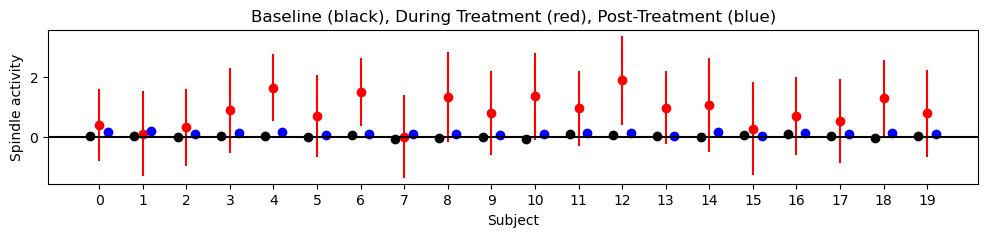

In [18]:
# Plot the spiking from an example neuron.
plt.figure(figsize=(12, 2))
for k in np.arange(0,20):
    mn = np.mean(baseline[:,k]);
    sd = np.std( baseline[:,k]);
    K  = np.shape(baseline)[0];
    plt.plot(k-0.2, mn, 'o', color='k')
    plt.plot([k-0.2,k-0.2], [mn-2*sd/np.sqrt(K), mn+2*sd/np.sqrt(K)], color='k')
for k in np.arange(0,20):
    mn = np.mean(during_treatment[:,k]);
    sd = np.std( during_treatment[:,k]);
    K  = np.shape(during_treatment)[0];
    plt.plot(k, mn, 'o', color='r')
    plt.plot([k,k], [mn-2*sd/np.sqrt(K), mn+2*sd/np.sqrt(K)], color='r')
for k in np.arange(0,20):
    mn = np.mean(post_treatment[:,k]);
    sd = np.std( post_treatment[:,k]);
    K  = np.shape(post_treatment)[0];
    plt.plot(k+0.2, mn, 'o', color='b')
    plt.plot([k+0.2,k+0.2], [mn-2*sd/np.sqrt(K), mn+2*sd/np.sqrt(K)], color='b')
plt.axhline(y=0, color='k')
plt.xlabel('Subject'); plt.ylabel('Spindle activity'); plt.title('Baseline (black), During Treatment (red), Post-Treatment (blue)');
plt.xticks(np.arange(0,20));

<div class="alert alert-block alert-success">

**Q:** Looking at the summary plots of the spindle activty for each subject, do you observe an effect during `treatment` (red)?

**A:** (Short answer)

- Yes ... the mean spindle activity during `treatment` appears larger than `baseline`. The standard error is also large. Why are the p-values during `treatement` not significant?

</div>

<div class="alert alert-block alert-success">

**Q:** Looking at the summary plots of the spindle activty for each subject, do you observe an effect `post-treatment` (blue)?

**A:** (Short answer) 

- Not really ... because we find significnt p-values `post-treatment`, I expect these values to differ from 0. But I don't see that here, the black and blue dots appear to overlap near 0.

</div>

<div class="alert alert-block alert-success">

**Q:** Looking at the summary plots of the spindle activty for each subject, are these plots consistent with your p-value results?

**A:** (Short answer)

- Not really ... we concluded that there's an effect `post-treatment`, but not during `treatment`. However, these plots of spindle activity aren't consistent with our conclusions.

</div>

Let's summarize what we've found so far:

| State | p-values | spindle activity |
|----------|----------|----------|
| During treatment   | p>0.05/20 (not significant) | mean spindle activity > 0   |
| Post-treatment    | p<<0.05/20  (signficiant)   | mean spindle activity $\approx$ 0.   |

Something's not adding up here ... 

- During `treatment`, we find **no** evidence of a signficant change in spindle activity from baseline (i.e., the p-values are big). However, looking at the mean spindle activity, we find spindle activities that often exceed 0.

- `Post-treatment`, we find evidence in 9/20 subject of a signficant change in spindle activity from baseline (i.e., the p-values are small). However, looking at the mean spindle activity, we find those values tend to appear near 0.

<div class="alert alert-block alert-success">

**Q:** Why do the spindle activities during `treatment` often exceed 0 (i.e., exceed baseline) spindle activity, but p>0.05? And, why are the `post-treatment` spindle activities so near 0 (i.e., so near the baseline) spindle activity, but p<<0.05?
    
**A:** I'm confused!
</div>

<div class="alert alert-block alert-danger">
<b>Alert:</b>
    
These confusing conclusions occur because **we've made two common errors**:

- We compared p-values between the `treatment` and `post-treatment` groups.

- We focused exclusively on p-values without thinking more carefully about the data used to compute those p-values.

</p>
</div>

## To resolve these confusing conclusions, let's think more carefully about what the p-value represents.

The p-value measures the strength of evidence against the null hypothesis.

Three factors can impact the strength of evidence:

- **Sample Size** (i.e., the number of observations).
- **Effect Size** (i.e., bigger differences in spindle activity between conditions are easier to detect.) 
- **Variability (or Noise) in Measurements**: (i.e., how reliably we measure spindle activity).

<div class="alert alert-block alert-success">

**Q:** How does the **sample size** differ during `treatment` versus `post-treatment`? How might this impact the results?
    
**A:**
- We have many more observations `post-treatment` (N=840). Therefore, we can accumulate enough evidence to detect a weak effect post-treatment.
- We have few observations during `treatment` (N=30). Therefore, even though the effect may be strong, we don't have enough evidence to reject the null hypothesis of no difference from 0 (i.e., no difference from `baseline`) during treatment.
</div>

<div class="alert alert-block alert-success">

**Q:** How does the **effect size** differ during `treatment` versus `post-treatment`? How might this impact the results?
    
**A:**
- The effect size appears small `post-treatment` (the mean values are near zero). Therefore, although we detect a change `post-treatment`, this change is small.
- The effect size appears large during `treatment` (the mean values exceed zero). However, due to the limited number of samples and variability in the estimates, we do not have enough evidence to reject the null hypothesis of no difference from 0 (i.e., no difference from `baseline`) during treatment.
</div>

<div class="alert alert-block alert-success">

**Q:** How does the **measurement variability** differ during `treatment` versus `post-treatment`? How might this impact the results?
    
**A:**

- We have less measurement variability `post-treatment`. Lower variability makes it easier to detect a difference from 0 (i.e., difference from `baseline`).

- We have more measurement variability during `treatment` . Higher variability makes it harder to detect a difference from 0 (i.e., difference from `baseline`) and harder to reject the null hypothesis.
</div>

## Conclusion / Summary / Morale:

We began with the scientific statement:

*“I expect during treatment that spindle activity exceeds the baseline spindle activity.”*

Our initial approach focused on computing and comparing p-values.

That's a bad idea.

We're not interested in comparing the **evidence** we have for each null-hypothesis (the p-value); the evidence depends on the sample size, effect size, and measurement variability.

Instead, we're more interested in comparing the spindle activity between condidtions.

In other words, **we're intested in the effect size**, not the p-value.

This suggests a different analysis path forward for an improved approach.

We can answer the same scienfitic question by **comparing the spindle activities between conditions**, not the p-values.

We've started to see this in the plots of spindle activity at `baseline`, during `treatment`, and `post-treatment`.

For more analysis (e.g., different statistical test and effect size) continue on to the other Minis.


# 5- Refine your hypothesis test to match your scientific question.


Originally (in Mini 2), we considered the null hypothesis:

- **Null hypothesis** (Mini 2): Mean spindle rate during treatment = 0.

That was a fine initial approach.

However, it limited us to the small number (N=30) of noisy samples recorded during `treatment` for each subject.

We focused our analysis on whether these values differed from 0 (the `baseline` spindle activity). 

And we found no evidence to reject the null hypothesis.

---

While this initial appraoch does test our scientific question, there's a more powerful appraoch.

Instead of testing whether spindle activity during `treatment` differs from 0, let's directly compare the spindle activity during `baseline` and `treatment`.

In particular, let's now consider **a different null hypothesis**:

- **Null hypothesis** (Mini 5): No difference in mean spindle activity during treatment **versus baseline**.

This null hypothesis is consistent with our original scientific question (does the spindle activity during `treatment` differ from `baseline`).

In our original analysis, we compared the spindle activity during `treatment` to a fixed value of 0.

In doing so, we ignored the many samples (N=840) collected during `baseline`.

Now, in our new appraoch, we'll use all of the samples collected during the `baseline` spindle activity, and incorportae these many `baseline` samples into our analysis.

To test our new null hypothesis, we'll apply a different test:

- a subject specific two-sample t-test.

In [21]:
result = stats.ttest_ind(baseline, during_treatment, alternative='less')
p_value_baseline_vs_during = result.pvalue
for k in np.arange(0,20):
    print('Subject ', k, ', p=', np.array2string(p_value_baseline_vs_during[k], precision=4))

Subject  0 , p= 0.0364
Subject  1 , p= 0.3733
Subject  2 , p= 0.0704
Subject  3 , p= 7.712e-05
Subject  4 , p= 1.7514e-15
Subject  5 , p= 0.0008
Subject  6 , p= 1.0667e-12
Subject  7 , p= 0.3702
Subject  8 , p= 2.5241e-09
Subject  9 , p= 0.0001
Subject  10 , p= 1.6325e-10
Subject  11 , p= 2.7851e-05
Subject  12 , p= 3.2021e-16
Subject  13 , p= 1.5163e-05
Subject  14 , p= 4.2159e-06
Subject  15 , p= 0.1733
Subject  16 , p= 0.0024
Subject  17 , p= 0.0152
Subject  18 , p= 7.0189e-10
Subject  19 , p= 0.0004


Significant p-values during treatment =  14


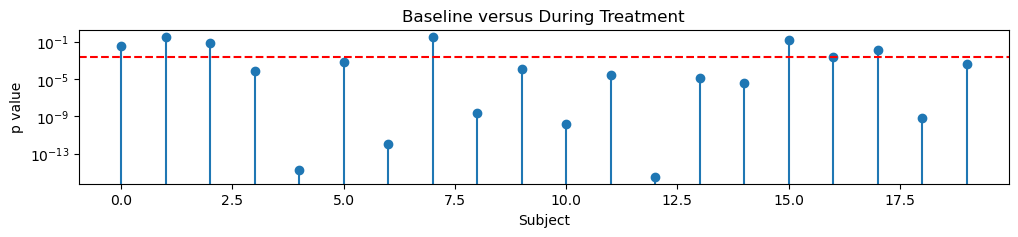

In [22]:
plt.figure(figsize=(12, 2))
plt.stem(p_value_baseline_vs_during);
plt.axhline(y=0.05/20, color='r', linestyle='--')
plt.xlabel('Subject'); plt.ylabel('p value'); plt.title('Baseline versus During Treatment'); plt.yscale('log')
print('Significant p-values during treatment = ',np.sum(p_value_baseline_vs_during < 0.05/20))

<div class="alert alert-block alert-success">

**Q:** Interpret these p-value results in terms of the null hypothesis.

**A:** We conclude that, in most cases, we reject the null hypothesis of no difference in spindle activity between baseline versus during treatment. We conclude that the spindle activity is higher during treatment compared to baseline in most subjects (14/20).

</div>

<div class="alert alert-block alert-success">

**Q:** Compare the results of these tests for each human to the results in Mini 2.

**A:** In Mini 2, we computed p-values during treatment versus 0. Now, we compute p-values during treatment versus baseline. These are different tests. The latter tests more directly our scientific question.

</div>

# 6- So, what went wrong?

What is the scientifc question we're actually trying to answer?

(PENDING): Impact of Sample Size on Evidence

(REVIEW): Impact of Measurement Variability on Evidence

# 7- One test to rule them all: an omnibus test.

(PENDING)

# 8- Beyond p-values: estimate what you care about.


(PENDING): estimate effect size during & post, and compare.

# 9- Summary

(PENDING)